In [ ]:
from keras_applications import get_submodules_from_kwargs

from ._common_blocks import Conv2dBn
from ._utils import freeze_model, filter_keras_submodules
from ..backbones.backbones_factory import Backbones

backend = None
layers = None
models = None
keras_utils = None


# ---------------------------------------------------------------------
#  Utility functions
# ---------------------------------------------------------------------

def get_submodules():
    return {
        'backend': backend,
        'models': models,
        'layers': layers,
        'utils': keras_utils,
    }


def check_input_shape(input_shape, factor):
    if input_shape is None:
        raise ValueError("Input shape should be a tuple of 3 integers, not None!")

    h, w = input_shape[:2] if backend.image_data_format() == 'channels_last' else input_shape[1:]
    min_size = factor * 6

    is_wrong_shape = (
            h % min_size != 0 or w % min_size != 0 or
            h < min_size or w < min_size
    )

    if is_wrong_shape:
        raise ValueError('Wrong shape {}, input H and W should '.format(input_shape) +
                         'be divisible by `{}`'.format(min_size))


# ---------------------------------------------------------------------
#  Blocks
# ---------------------------------------------------------------------

def Conv1x1BnReLU(filters, use_batchnorm, name=None):
    kwargs = get_submodules()

    def wrapper(input_tensor):
        return Conv2dBn(
            filters,
            kernel_size=1,
            activation='relu',
            kernel_initializer='he_uniform',
            padding='same',
            use_batchnorm=use_batchnorm,
            name=name,
            **kwargs
        )(input_tensor)

    return wrapper


def SpatialContextBlock(
        level,
        conv_filters=512,
        pooling_type='avg',
        use_batchnorm=True,
):
    if pooling_type not in ('max', 'avg'):
        raise ValueError('Unsupported pooling type - `{}`.'.format(pooling_type) +
                         'Use `avg` or `max`.')

    Pooling2D = layers.MaxPool2D if pooling_type == 'max' else layers.AveragePooling2D

    pooling_name = 'psp_level{}_pooling'.format(level)
    conv_block_name = 'psp_level{}'.format(level)
    upsampling_name = 'psp_level{}_upsampling'.format(level)

    def wrapper(input_tensor):
        # extract input feature maps size (h, and w dimensions)
        input_shape = backend.int_shape(input_tensor)
        spatial_size = input_shape[1:3] if backend.image_data_format() == 'channels_last' else input_shape[2:]

        # Compute the kernel and stride sizes according to how large the final feature map will be
        # When the kernel factor and strides are equal, then we can compute the final feature map factor
        # by simply dividing the current factor by the kernel or stride factor
        # The final feature map sizes are 1x1, 2x2, 3x3, and 6x6.
        pool_size = up_size = [spatial_size[0] // level, spatial_size[1] // level]

        x = Pooling2D(pool_size, strides=pool_size, padding='same', name=pooling_name)(input_tensor)
        x = Conv1x1BnReLU(conv_filters, use_batchnorm, name=conv_block_name)(x)
        x = layers.UpSampling2D(up_size, interpolation='bilinear', name=upsampling_name)(x)
        return x

    return wrapper


# ---------------------------------------------------------------------
#  PSP Decoder
# ---------------------------------------------------------------------

def build_psp(
        backbone,
        psp_layer_idx,
        pooling_type='avg',
        conv_filters=512,
        use_batchnorm=True,
        final_upsampling_factor=8,
        classes=21,
        activation='softmax',
        dropout=None,
):
    input_ = backbone.input
    x = (backbone.get_layer(name=psp_layer_idx).output if isinstance(psp_layer_idx, str)
         else backbone.get_layer(index=psp_layer_idx).output)

    # build spatial pyramid
    x1 = SpatialContextBlock(1, conv_filters, pooling_type, use_batchnorm)(x)
    x2 = SpatialContextBlock(2, conv_filters, pooling_type, use_batchnorm)(x)
    x3 = SpatialContextBlock(3, conv_filters, pooling_type, use_batchnorm)(x)
    x6 = SpatialContextBlock(6, conv_filters, pooling_type, use_batchnorm)(x)

    # aggregate spatial pyramid
    concat_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    x = layers.Concatenate(axis=concat_axis, name='psp_concat')([x, x1, x2, x3, x6])
    x = Conv1x1BnReLU(conv_filters, use_batchnorm, name='aggregation')(x)

    # model regularization
    if dropout is not None:
        x = layers.SpatialDropout2D(dropout, name='spatial_dropout')(x)

    # model head
    x = layers.Conv2D(
        filters=classes,
        kernel_size=(3, 3),
        padding='same',
        kernel_initializer='glorot_uniform',
        name='final_conv',
    )(x)

    x = layers.UpSampling2D(final_upsampling_factor, name='final_upsampling', interpolation='bilinear')(x)
    x = layers.Activation(activation, name=activation)(x)

    model = models.Model(input_, x)

    return model


# ---------------------------------------------------------------------
#  PSP Model
# ---------------------------------------------------------------------

def PSPNet(
        backbone_name='vgg16',
        input_shape=(384, 384, 3),
        classes=21,
        activation='softmax',
        weights=None,
        encoder_weights='imagenet',
        encoder_freeze=False,
        downsample_factor=8,
        psp_conv_filters=512,
        psp_pooling_type='avg',
        psp_use_batchnorm=True,
        psp_dropout=None,
        **kwargs
):
    """PSPNet_ is a fully convolution neural network for image semantic segmentation
    Args:
        backbone_name: name of classification model used as feature
                extractor to build segmentation model.
        input_shape: shape of input data/image ``(H, W, C)``.
            ``H`` and ``W`` should be divisible by ``6 * downsample_factor`` and **NOT** ``None``!
        classes: a number of classes for output (output shape - ``(h, w, classes)``).
        activation: name of one of ``keras.activations`` for last model layer
                (e.g. ``sigmoid``, ``softmax``, ``linear``).
        weights: optional, path to model weights.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        encoder_freeze: if ``True`` set all layers of encoder (backbone model) as non-trainable.
        downsample_factor: one of 4, 8 and 16. Downsampling rate or in other words backbone depth
            to construct PSP module on it.
        psp_conv_filters: number of filters in ``Conv2D`` layer in each PSP block.
        psp_pooling_type: one of 'avg', 'max'. PSP block pooling type (maximum or average).
        psp_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
                is used.
        psp_dropout: dropout rate between 0 and 1.
    Returns:
        ``keras.models.Model``: **PSPNet**
    .. _PSPNet:
        https://arxiv.org/pdf/1612.01105.pdf
    """

    global backend, layers, models, keras_utils
    submodule_args = filter_keras_submodules(kwargs)
    backend, layers, models, keras_utils = get_submodules_from_kwargs(submodule_args)

    # control image input shape
    check_input_shape(input_shape, downsample_factor)

    backbone = Backbones.get_backbone(
        backbone_name,
        input_shape=input_shape,
        weights=encoder_weights,
        include_top=False,
        **kwargs
    )

    feature_layers = Backbones.get_feature_layers(backbone_name, n=3)

    if downsample_factor == 16:
        psp_layer_idx = feature_layers[0]
    elif downsample_factor == 8:
        psp_layer_idx = feature_layers[1]
    elif downsample_factor == 4:
        psp_layer_idx = feature_layers[2]
    else:
        raise ValueError('Unsupported factor - `{}`, Use 4, 8 or 16.'.format(downsample_factor))

    model = build_psp(
        backbone,
        psp_layer_idx,
        pooling_type=psp_pooling_type,
        conv_filters=psp_conv_filters,
        use_batchnorm=psp_use_batchnorm,
        final_upsampling_factor=downsample_factor,
        classes=classes,
        activation=activation,
        dropout=psp_dropout,
    )

    # lock encoder weights for fine-tuning
    if encoder_freeze:
        freeze_model(backbone, **kwargs)

    # loading model weights
    if weights is not None:
        model.load_weights(weights)

    return model

In [4]:
import numpy as np, os, pickle, cv2, glob
from imageio import imread
from keras.callbacks import ModelCheckpoint
from sklearn import metrics
from imageio import imsave
from pathlib import Path



from prepare_data import *
from data_process import *
from model import *


def Sens(y_true, y_pred):
    cm1 = metrics.confusion_matrix(y_true, y_pred, labels=[1, 0])  # labels =[1,0] [positive [Hemorrhage], negative]
    SensI = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
    return SensI  # TPR is also known as sensitivity

def Speci(y_true, y_pred):
    cm1 = metrics.confusion_matrix(y_true, y_pred, labels=[1, 0])  # labels =[1,0] [positive [Hemorrhage], negative]
    SpeciI = cm1[1, 1] / (cm1[1, 0] + cm1[1, 1])
    return SpeciI  # FPR is one minus the specificity or true negative rate

def Jaccard_img(y_true, y_pred): #https://www.jeremyjordan.me/evaluating-image-segmentation-models/
    iou_score=0
    counter=0
    for i in range(y_true.shape[0]):
        if np.sum(y_true[i])>0:#Considering only the slices that have hemorrhage regions, if y_true is all zeros -> iou_score=nan.
            im1 = np.asarray(y_true[i], dtype=bool)
            im2 = np.asarray(y_pred[i], dtype=bool)
            intersection = np.logical_and(im1, im2)
            union = np.logical_or(im1, im2)
            iou_score+= np.sum(intersection) / np.sum(union)
            counter+=1
    if counter>0:
        return iou_score/counter
    else:
        return np.nan


def dice_img(y_true, y_pred):
    dice=0
    counter = 0
    for i in range(y_true.shape[0]):
        if np.sum(y_true[i]) > 0:  # Considering only the slices that have hemorrhage regions,
            dice += dice_fun(y_true[i], y_pred[i])
            counter += 1
    if counter>0:
        return dice/counter
    else:
        return np.nan

def dice_fun(im1, im2):
    im1 = np.asarray(im1, dtype=bool)
    im2 = np.asarray(im2, dtype=bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())



def testModel(model_path,test_path,save_path):
    modelPSPnet = PSPnet(pretrained_weights=model_path, input_size =(windowLen,windowLen,1) )
    testGener = testGenerator(test_path, target_size =(windowLen,windowLen,1))
    testPredictions = modelPSPnet.predict(testGener,n_imagesTest,verbose=1)
    saveResult(test_path,save_path,testPredictions) #sending the test image path so same name will be used for saving masks


data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    #brightness_range=(0,1.5),
    fill_mode="nearest"
    )



if __name__=='__main__':
    #############################################Training Parameters#######################################################
    num_CV=5
    #NumEpochs=100
    NumEpochs= 40
    NumEpochEval=1 #validated the model each NumEpochEval epochs
    batch_size = 32
    learning_rateI = 1e-5
    decayI=learning_rateI/NumEpochs
    detectionSen=20*20# labeling each slice as ICH if hemorrhage is detected in detectionSen pixels
    thresholdI= 0.5
    detectionThreshold=thresholdI*256  #threshold on detection probability
    numSubj = 75
    num_WindowsCT=49
    imageLen = 512
    windowLen = 128
    strideLen = 64
    num_Moves = int(imageLen/strideLen)-1
    window_specs = [40, 120]  # Brain window
    kernel_closing = np.ones((10, 10), np.uint8)
    kernel_opening = np.ones((5, 5), np.uint8)# 5*5 in order not to delete thin hemorrhage

    counterI=1; SaveDir = Path('results_trial'+str(counterI))
    while(os.path.isdir(str(SaveDir))):
        counterI+=1
        SaveDir= Path('results_trial'+str(counterI))
    os.mkdir(str(SaveDir))
    os.mkdir(str(Path(SaveDir,'crops')))
    os.mkdir(str(Path(SaveDir,'fullCT_original')))#Testing without morphological operations
    os.mkdir(str(Path(SaveDir, 'fullCT_morph'+ str(thresholdI)))) #Testing with morphological operations
    print('The results of the training, validation and testing will be saved to:'+ str(SaveDir))



    #############################################Downloading and unzipping the dataset######################################
    dataset_zip_dir='computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1.zip'
    crossvalid_dir='DataV1'
    prepare_data(dataset_zip_dir, crossvalid_dir, numSubj, imageLen, windowLen, strideLen,
                 num_Moves, window_specs) #preparing the data and saving it to ICH_DataSegmentV1.pkl

    # Loading full image mask from the crops predictions
    with open(str(Path(crossvalid_dir,'ICH_DataSegmentV1.pkl')), 'rb') as Dataset1:
        [hemorrhageDiagnosisArray, AllCTscans, testMasks, subject_nums_shaffled] = pickle.load(Dataset1)
    del AllCTscans
    testMasks=np.uint8(testMasks)
    testMasksAvg = np.where(np.sum(np.sum(testMasks, axis=1), axis=1) > detectionSen, 1, 0)  #
    testPredictions=np.zeros((testMasks.shape[0],imageLen,imageLen),dtype=np.uint8) #predicted segmentation

    ############################################Cross-validation############################################################
    print('Starting the cross-validation!!')
    for cvI in range(0,num_CV):
        print("Working on fold #" + str(cvI)+", starting training U-Net")
        SaveDir_crops_cv=Path(SaveDir,'crops','CV'+str(cvI))
        if os.path.isdir(str(SaveDir_crops_cv))==False:
            os.mkdir(str(SaveDir_crops_cv))
        SaveDir_full_cv=Path(SaveDir,'fullCT_original','CV'+str(cvI))
        if os.path.isdir(str(SaveDir_full_cv))==False:
            os.mkdir(str(SaveDir_full_cv))
        SaveDir_cv = Path(SaveDir, 'fullCT_morph' + str(thresholdI), 'CV' + str(cvI))
        if os.path.isdir(str(SaveDir_cv)) == False:
            os.mkdir(str(SaveDir_cv))

        dataDir = Path(crossvalid_dir,'CV'+str(cvI))
        n_imagesTrain=len(glob.glob(os.path.join(str(Path(dataDir,'train','image')), "*.png")))
        n_imagesValidate=len(glob.glob(os.path.join(str(Path(dataDir,'validate','image')), "*.png")))
        n_imagesTest = len(glob.glob(os.path.join(str(Path(dataDir,'test','crops','image')), "*.png")))
        trainGener = trainGenerator(batch_size,str(Path(dataDir,'train')),'image','label',data_gen_args,save_to_dir = None, target_size = (128,128))
        valGener = validateGenerator(batch_size,str(Path(dataDir,'validate')), 'image', 'label', save_to_dir=None, target_size = (128,128))
        modelPSPnet = PSPnet(learningRate=learning_rateI,decayRate=decayI, input_size =(windowLen,windowLen,1) )
        model_checkpoint = ModelCheckpoint(str(Path(SaveDir,'PSPnet_CV'+str(cvI)+'.hdf5')), monitor='val_jaccard_loss', mode='min',
                                           verbose=1, save_best_only=True, period=NumEpochEval)
        history1=modelPSPnet.fit(trainGener,epochs=NumEpochs,steps_per_epoch=int(n_imagesTrain/batch_size),
                                        validation_data=valGener,validation_steps=n_imagesValidate,callbacks=[model_checkpoint])

        with open(str(Path(SaveDir,'history_CV'+str(cvI)+'.pkl')), 'wb') as Results:  # Python 3: open(..., 'wb')
            pickle.dump(
                [history1.history], Results)

        #Loading and testing the model with lowest validation loss
        print('Testing the best U-Net model on testing data and saving the results to: '+str(SaveDir_crops_cv))
        testModel(str(Path(SaveDir, 'PSPnet_CV' + str(cvI) + '.hdf5')), str(Path(dataDir,'test','crops','image')),
                      str(SaveDir_crops_cv))

        #Creating full image mask from the crops predictions
        if cvI < num_CV - 1:
            subjectNums_cvI_testing = subject_nums_shaffled[cvI * int(numSubj / num_CV):cvI * int(numSubj / num_CV) + int(numSubj / num_CV)]
        else:
            subjectNums_cvI_testing = subject_nums_shaffled[cvI * int(numSubj / num_CV):numSubj]

        #Finding the predictions or ICH segmentation for the whole slice
        print('Combining the crops masks to find the full CT mask after performing morphological operations and saving the results to: ' + str(SaveDir_full_cv))
        for subItest in range(0, len(subjectNums_cvI_testing)):
            slicenum_s = hemorrhageDiagnosisArray[hemorrhageDiagnosisArray[:, 0] == subjectNums_cvI_testing[subItest], 1]
            sliceInds = np.where(hemorrhageDiagnosisArray[:, 0] == subjectNums_cvI_testing[
                subItest])  # using the slice index to keep the predictions have the same sequence as the ground truth.
            counterSlice = 0
            for sliceI in range(slicenum_s.size):
                #reading the predicted segmentation for each window
                CTslicePredict = np.zeros((imageLen, imageLen))
                windowOcc = np.zeros((imageLen, imageLen))  # number of predictions for each pixel in the CT scan
                counterCrop = 0
                for i in range(num_Moves):
                    for j in range(num_Moves):
                        windowI = imread(Path(SaveDir_crops_cv,str(subjectNums_cvI_testing[subItest])
                                      + '_' + str(sliceI) +'_'+ str(counterCrop)+ '.png'))
                        windowI = windowI / 255
                        CTslicePredict[int(i * imageLen / (num_Moves + 1)):int(i * imageLen / (num_Moves + 1) + windowLen),
                            int(j * imageLen / (num_Moves + 1)):int(j * imageLen / (num_Moves + 1) + windowLen)]= CTslicePredict[int(i * imageLen / (num_Moves + 1)):int(i * imageLen / (num_Moves + 1) + windowLen),
                            int(j * imageLen / (num_Moves + 1)):int(j * imageLen / (num_Moves + 1) + windowLen)]+windowI
                        windowOcc[int(i * imageLen / (num_Moves + 1)):int(i * imageLen / (num_Moves + 1) + windowLen),
                            int(j * imageLen / (num_Moves + 1)):int(j * imageLen / (num_Moves + 1) + windowLen)]= windowOcc[int(i * imageLen / (num_Moves + 1)):int(i * imageLen / (num_Moves + 1) + windowLen),
                            int(j * imageLen / (num_Moves + 1)):int(j * imageLen / (num_Moves + 1) + windowLen)]+1
                        counterCrop = counterCrop + 1
                CTslicePredict=CTslicePredict / windowOcc *255
                img=np.uint8(CTslicePredict)
                imsave(Path(SaveDir_full_cv,str(subjectNums_cvI_testing[subItest])
                                      + '_' + str(sliceI) + '.png'), img)

                img = np.int16(np.where(img > detectionThreshold, 255, 0))
                img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_closing)  # Filling the gaps
                img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_opening)
                imsave(Path(SaveDir_cv,str(subjectNums_cvI_testing[subItest])
                            + '_' + str(sliceI) + '.png'), np.uint8(img))
                testPredictions[sliceInds[0][counterSlice]] = np.uint8(np.where(img > (0.5*256), 1, 0))
                counterSlice+=1

        K.clear_session()

    CVtestPredictionsAvg = np.where(np.sum(np.sum(testPredictions,axis=1),axis=1) > detectionSen, 1, 0) #

    #Calculating the Final Testing Results for all CV iterations, results for pixel-wise classification
    class_report=np.zeros((numSubj,14))
    for subjI in range(numSubj):
        sliceInds = np.where(hemorrhageDiagnosisArray[:, 0] == subjI)[0]
        class_report[subjI,0]=Jaccard_img(testMasks[sliceInds],testPredictions[sliceInds])
        class_report[subjI,1] = dice_img(testMasks[sliceInds], testPredictions[sliceInds])
        #Results for slice-wise classification
        class_report[subjI,2] = metrics.accuracy_score(testMasksAvg,CVtestPredictionsAvg)
        class_report[subjI,3] = metrics.recall_score(testMasksAvg,CVtestPredictionsAvg, pos_label=1)
        class_report[subjI,4] = metrics.precision_score(testMasksAvg,CVtestPredictionsAvg, pos_label=1)
        class_report[subjI,5] = metrics.f1_score(testMasksAvg,CVtestPredictionsAvg, pos_label=1)
        class_report[subjI,6] = Sens(testMasksAvg,CVtestPredictionsAvg)  # TPR is also known as sensitivity
        class_report[subjI,7] = Speci(testMasksAvg,CVtestPredictionsAvg)  # FPR is one minus the specificity or true negative rate

    class_report[21, :] = np.nan  
    print("Final pixel-wise testing: mean Jaccard %.3f (max %.3f, min %.3f, +- %.3f), mean Dice %.3f (max %.3f, min %.3f, +- %.3f)" % (
            np.nanmean(class_report[:,0]), np.nanmax(class_report[:,0]),np.nanmin(class_report[:,0]),np.nanstd(class_report[:,0]),
            np.nanmean(class_report[:,1]),np.nanmax(class_report[:,1]),np.nanmin(class_report[:,1]), np.nanstd(class_report[:,1])))
    print("Final testing: Accuracy %.3f (max %.3f, min %.3f, +- %.3f), Sensi %.4f (max %.3f, min %.3f, +- %.3f), Speci %.4f (max %.3f, min %.3f, +- %.3f))." % (
                np.nanmean(class_report[:,2]),np.nanmax(class_report[:,2]),np.nanmin(class_report[:,2]),np.nanstd(class_report[:,2])
                ,np.nanmean(class_report[:,3]), np.nanmax(class_report[:,3]),np.nanmin(class_report[:,3]),np.nanstd(class_report[:,3])
                ,np.nanmean(class_report[:,3]), np.nanmax(class_report[:,3]), np.nanmin(class_report[:,3]),np.nanstd(class_report[:,3])))

    with open(str(Path(SaveDir,'fullCT_morph' + str(thresholdI),'report.pkl')), 'wb') as Results:  # Python 3: open(..., 'wb')
        pickle.dump(
            [class_report, testMasks,testPredictions], Results)

The results of the training, validation and testing will be saved to:results_trial6
The dataset is already downloaded and the cross-validation folds were created!
Starting the cross-validation!!
Working on fold #0, starting training U-Net
Found 1818 images belonging to 1 classes.
Found 1818 images belonging to 1 classes.
Epoch 1/40
56/56 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.9191 - jaccard_loss: 0.9454Found 520 images belonging to 1 classes.
Found 520 images belonging to 1 classes.

Epoch 1: val_jaccard_loss improved from inf to 0.96822, saving model to results_trial6\unet_CV0.hdf5
56/56 [==============================] - 58s 1s/step - loss: 0.6946 - accuracy: 0.9191 - jaccard_loss: 0.9454 - val_loss: 0.6930 - val_accuracy: 0.9651 - val_jaccard_loss: 0.9682
Epoch 2/40
56/56 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.9421 - jaccard_loss: 0.9459
Epoch 2: val_jaccard_loss improved from 0.96822 to 0.96812, saving model to resul

Epoch 22/40
56/56 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.9412 - jaccard_loss: 0.9447
Epoch 22: val_jaccard_loss did not improve from 0.96786
56/56 [==============================] - 55s 1s/step - loss: 0.6879 - accuracy: 0.9412 - jaccard_loss: 0.9447 - val_loss: 0.6874 - val_accuracy: 0.9670 - val_jaccard_loss: 0.9680
Epoch 23/40
56/56 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.9421 - jaccard_loss: 0.9455
Epoch 23: val_jaccard_loss did not improve from 0.96786
56/56 [==============================] - 55s 991ms/step - loss: 0.6876 - accuracy: 0.9421 - jaccard_loss: 0.9455 - val_loss: 0.6872 - val_accuracy: 0.9669 - val_jaccard_loss: 0.9680
Epoch 24/40
56/56 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.9428 - jaccard_loss: 0.9460
Epoch 24: val_jaccard_loss did not improve from 0.96786
56/56 [==============================] - 55s 989ms/step - loss: 0.6874 - accuracy: 0.9428 - jaccard_loss: 0.9460 - va

Epoch 3/40
56/56 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9415 - jaccard_loss: 0.9357
Epoch 3: val_jaccard_loss improved from 0.95287 to 0.94462, saving model to results_trial6\unet_CV1.hdf5
56/56 [==============================] - 65s 1s/step - loss: 0.2053 - accuracy: 0.9415 - jaccard_loss: 0.9357 - val_loss: 0.3089 - val_accuracy: 0.9575 - val_jaccard_loss: 0.9446
Epoch 4/40
56/56 [==============================] - ETA: 0s - loss: 0.1863 - accuracy: 0.9408 - jaccard_loss: 0.9117
Epoch 4: val_jaccard_loss did not improve from 0.94462
56/56 [==============================] - 65s 1s/step - loss: 0.1863 - accuracy: 0.9408 - jaccard_loss: 0.9117 - val_loss: 0.3223 - val_accuracy: 0.9576 - val_jaccard_loss: 0.9459
Epoch 5/40
56/56 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.9408 - jaccard_loss: 0.8918
Epoch 5: val_jaccard_loss did not improve from 0.94462
56/56 [==============================] - 65s 1s/step - loss: 0.1727 - accura

56/56 [==============================] - 66s 1s/step - loss: 0.0755 - accuracy: 0.9727 - jaccard_loss: 0.5534 - val_loss: 0.2500 - val_accuracy: 0.9149 - val_jaccard_loss: 0.9164
Epoch 26/40
56/56 [==============================] - ETA: 0s - loss: 0.0730 - accuracy: 0.9736 - jaccard_loss: 0.5271
Epoch 26: val_jaccard_loss did not improve from 0.91645
56/56 [==============================] - 65s 1s/step - loss: 0.0730 - accuracy: 0.9736 - jaccard_loss: 0.5271 - val_loss: 0.3208 - val_accuracy: 0.8690 - val_jaccard_loss: 0.9325
Epoch 27/40
56/56 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.9754 - jaccard_loss: 0.5077
Epoch 27: val_jaccard_loss did not improve from 0.91645
56/56 [==============================] - 65s 1s/step - loss: 0.0680 - accuracy: 0.9754 - jaccard_loss: 0.5077 - val_loss: 0.3431 - val_accuracy: 0.8601 - val_jaccard_loss: 0.9367
Epoch 28/40
56/56 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9730 - jaccard_loss: 0.53

Epoch 29/40
60/60 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.9783 - jaccard_loss: 0.5097
Epoch 29: val_jaccard_loss did not improve from 0.92876
60/60 [==============================] - 67s 1s/step - loss: 0.0604 - accuracy: 0.9783 - jaccard_loss: 0.5097 - val_loss: 0.3289 - val_accuracy: 0.8582 - val_jaccard_loss: 0.9326
Epoch 30/40
60/60 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9779 - jaccard_loss: 0.5094
Epoch 30: val_jaccard_loss improved from 0.92876 to 0.91616, saving model to results_trial6\unet_CV2.hdf5
60/60 [==============================] - 68s 1s/step - loss: 0.0617 - accuracy: 0.9779 - jaccard_loss: 0.5094 - val_loss: 0.2627 - val_accuracy: 0.8930 - val_jaccard_loss: 0.9162
Epoch 31/40
60/60 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9771 - jaccard_loss: 0.5160
Epoch 31: val_jaccard_loss did not improve from 0.91616
60/60 [==============================] - 66s 1s/step - loss: 0.0643 - 

Epoch 10/40
52/52 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.9467 - jaccard_loss: 0.9497
Epoch 10: val_jaccard_loss did not improve from 0.95937
52/52 [==============================] - 65s 1s/step - loss: 0.6910 - accuracy: 0.9467 - jaccard_loss: 0.9497 - val_loss: 0.6908 - val_accuracy: 0.9575 - val_jaccard_loss: 0.9595
Epoch 11/40
52/52 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.9484 - jaccard_loss: 0.9513
Epoch 11: val_jaccard_loss did not improve from 0.95937
52/52 [==============================] - 64s 1s/step - loss: 0.6907 - accuracy: 0.9484 - jaccard_loss: 0.9513 - val_loss: 0.6905 - val_accuracy: 0.9576 - val_jaccard_loss: 0.9596
Epoch 12/40
52/52 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.9463 - jaccard_loss: 0.9493
Epoch 12: val_jaccard_loss did not improve from 0.95937
52/52 [==============================] - 64s 1s/step - loss: 0.6905 - accuracy: 0.9463 - jaccard_loss: 0.9493 - val_loss

KeyboardInterrupt: 

In [7]:
#preprocess = get_preprocessing('resnet101') # for resnet, img = (img-110.0)/1.0

# 'efficientnetb0'
# 'densenet121'

IMAGE_HEIGHT_ORIG = 650
IMAGE_WIDTH_ORIG = 650

NUM_TEST_IMAGES = 10 # 10 with intracranial hem + 10 without intracranial hem

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3

BATCH_SIZE = 10

BACKBONE = 'densenet121'
preprocess_input = get_preprocessing(BACKBONE)

# Note that the model takes 3-channel images as input
model = PSPnet(BACKBONE, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
             #freeze_encoder=False,
             classes=1, 
             encoder_weights='imagenet',
             activation='sigmoid')

In [21]:
img1 = "73_31.jpg"

from PIL import Image

prd = Image.open('ms.png')
prd1 = Image.open('ms2.png')
msk1 = Image.open('74_20_HGE_Seg.jpg')
msk2 = Image.open('73_31_HGE_Seg.jpg')

In [9]:
model.load_weights('model.h5')

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
img1 = "73_31.jpg"
img = image.load_img(img1, target_size=(256, 256))

In [16]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

In [17]:
prediction = model.predict(img_preprocessed)
preds_test_thresh = (prediction >= 0.4).astype(np.uint8)
preds_test_thresh.shape

1/1 [==============================] - 0s 34ms/step


(1, 256, 256, 1)

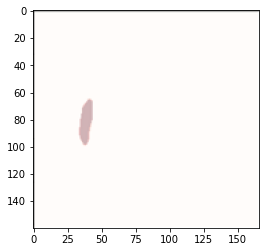

In [18]:
# This is a predicted mask
indx = 0
pred = preds_test_thresh[indx,:,:]
plt.imshow(prd)

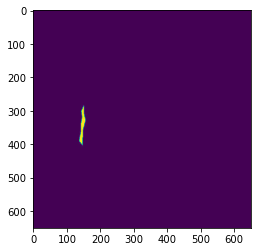

In [22]:
plt.imshow(msk1)

In [ ]:
# This is a predicted mask
indx = 1
pred = preds_test_thresh[indx,:,:]

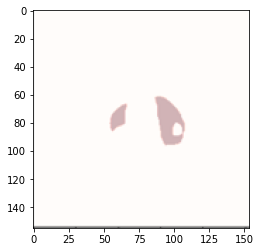

In [24]:
plt.imshow(prd1)

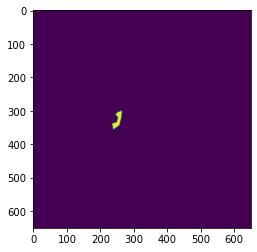

In [25]:
plt.imshow(msk2)